# Deep dive

In [1]:
from bhad import (model, utils)
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

### Draw from a two-component multivariate Student-t mixture distribution

Note: Anomaly class corresponds to the minority mixture component

In [2]:
seed = 42  
outlier_prob_true = .01         # probab. for outlier ; should be consistent with contamination rate in your model
k = 30                          # feature dimension 
N = 2*10**4                     # sample size

# Specify first and second moments for each component  
bvt = utils.mvt2mixture(thetas = {'mean1' : np.full(k,-1), 'mean2' : np.full(k,.5), 
                                'Sigma1' : np.eye(k)*.4, 'Sigma2' : np.eye(k)*.1, 
                                'nu1': 3.*k, 'nu2': 3.*k}, seed = seed, gaussian = False)

# Get latent draws and observations:
#------------------------------------
y_true, dataset = bvt.draw(n_samples = N, k = k, p = outlier_prob_true)

print(dataset.shape)

(20000, 30)


In [3]:
y_true.mean()    # probab. latent class 1 (=anomaly)

0.01025

In [4]:
yy = dataset['var0'].values

Plot Bart Simpson density:

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import norm

x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 1000)

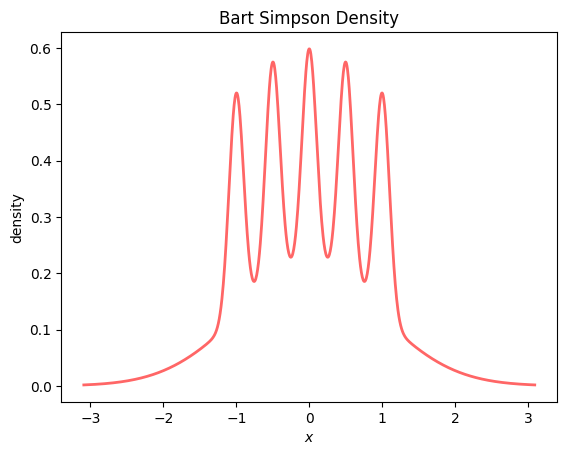

In [6]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, utils.bart_simpson_density(x, m = 4), 'r-', lw=2, alpha=0.6, label='norm pdf')
ax.set_xlabel(r'$x$')
ax.set_ylabel('density')
ax.set_title(r'Bart Simpson Density')
#fig.savefig('bart_simpson_density.png')   # save the figure to file
plt.show();
#plt.close(fig);    # close the figure window

In [7]:
opt_M = 50

grid = np.linspace(-4,4,100)

# Draw a sample via Accept/Reject sampling:
#-------------------------------------------
y = utils.rbartsim(MCsim = 10**4, seed = None, verbose = True)


Acceptance rate: 0.4702



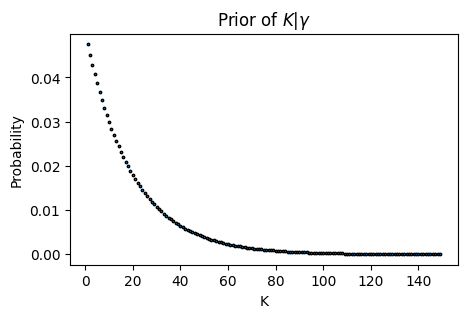

In [8]:
max_M = 150
gamma = 0.95
gp = [utils.geometric_prior(m, gamma = gamma, max_M = max_M) for m in range(1,max_M, 1)] 

fig = plt.figure(figsize=(5,3))
ax = plt.axes()
ax.scatter(range(1,max_M, 1), gp, s=3, edgecolors='black')
ax.set_xlabel(r'K')
ax.set_ylabel('Probability')     # unnormalized
ax.set_title(r'Prior of $K|\gamma$');

In [9]:
from scipy.integrate import simpson

gamma_grid = np.linspace(1e-4,1-1e-4, 30)

prior_max_M = 100

log_marg_prior_nbins = {}
for m in range(1, prior_max_M, 1):
    
    prior = np.array([utils.geometric_prior(M = m, gamma = g, max_M = prior_max_M, log = False) for g in gamma_grid])

    area = simpson(utils.exp_normalize(prior), gamma_grid)
    #area = simpson(prior, gamma_grid)
    
    log_marg_prior_nbins[m] = np.log(1e-10 + area)

log_marg_prior_nbins[58]

-3.4015676040742115

In [10]:
log_marg_post = {m : log_marg_prior_nbins[m] + utils.log_marglike_nbins(M = m, y = y) for m in range(1, prior_max_M, 1)}

# Compute K_MAP for each feature:
#---------------------------------
nopt_M = max(log_marg_post, key=log_marg_post.get)
opt_M

50

In [11]:
#log_marg_prior_nbins = {m : np.log(1e-10 + simpson(np.array([utils.geometric_prior(M = m, gamma = g, max_M = prior_max_M, log = False) for g in gamma_grid]), gamma_grid)) for m in range(1, prior_max_M, 1)}
#log_marg_prior_nbins

Plot posterior of number of bins:

In [12]:
post = utils.exp_normalize(np.array(list(log_marg_post.values())))
lpost = list(log_marg_post.values())
xx = np.array(list(log_marg_post.keys()))

In [13]:
#lpr = {m : log_marg_prior_nbins[m] + log_marglike_nbins(M = m, y = v) for m in range(1,self.prior_max_M, 1)}

In [14]:
m = 22

log_marg_prior_nbins = np.log(1e-10 + simpson(np.array([utils.geometric_prior(M = m, gamma = g, max_M = 100, log = False) for g in gamma_grid]), gamma_grid))
log_marg_prior_nbins

-6.25420915398745

In [15]:
#-----------------------------
# HPD of number of bins:
#-------------------------------
sig_level = 0.05
upper = np.sum(np.cumsum(post) <= (1-(sig_level/2))) 
lower = np.sum(np.cumsum(post) <= sig_level/2) 
median = np.sum(np.cumsum(post) <= 0.5) 
map = np.argmax(post) 
print(map)
print((lower, median, upper))

45
(45, 45, 53)


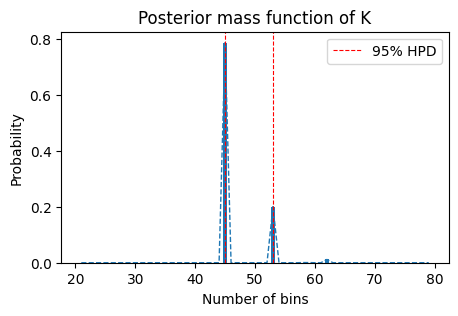

In [16]:
fig = plt.figure(figsize=(5,3))
ax = plt.axes()

s = xx[(xx > 20) & (xx < 80)] 
#ax.plot(xx, post)
ax.plot(s, post[s], '--', linewidth=1)
#ax.bar(s, post)
ax.bar(s, post[s])
#ax.scatter(s, pr)
ax.axvline(x = lower, color = 'red',linestyle = '--', linewidth=0.8, label = f'{int((1-sig_level)*100)}% HPD')
ax.axvline(x = upper, color = 'red',linestyle = '--', linewidth=0.8)
ax.set_xlabel('Number of bins')
ax.set_ylabel('Probability')
ax.legend(loc="upper right")
ax.set_title('Posterior mass function of K')
#fig.savefig('post_k.png')   # save the figure to file
plt.show();
#plt.close(fig)    # close the figure window

In [17]:
from scipy.stats import iqr

opt_sturges = int(1 + 3.322*np.log(len(y)))

print(f'\nMAP number of bins: {opt_M}')
print(f'Sturges rule: {opt_sturges}')

# Freedman-Diaconis rule:
bw = 2*iqr(y)*N**(-1/3)
FD = (max(y) - min(y))/bw
opt_fd = int(FD)
print(f'Freedman-Diaconis rule: {opt_fd}')


MAP number of bins: 50
Sturges rule: 29
Freedman-Diaconis rule: 73


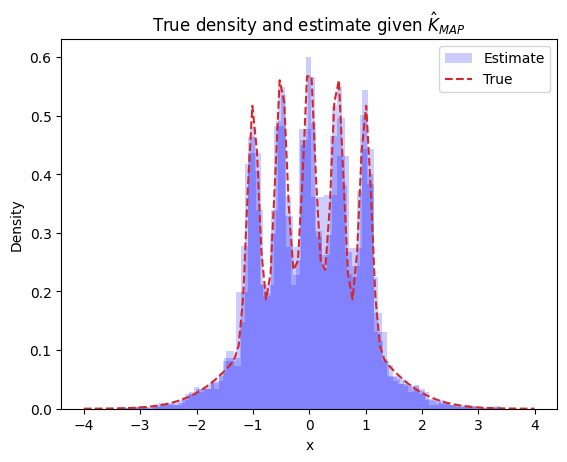

In [114]:
y_true = utils.bart_simpson_density(grid)

fig = plt.figure()
# create the histogram
counts1, bins1, patches1 = plt.hist(y, bins=opt_M + 1, density=True, facecolor='b', alpha=0.2, label='Estimate'); main = 'Bayes'
counts2, bins2, patches2 = plt.hist(y, bins=opt_fd + 1, density=True, facecolor='b', alpha=0.2); main = 'Freedman-Diaconis'
counts3, bins3, patches3 = plt.hist(y, bins=opt_sturges + 1, density=True, facecolor='b', alpha=0.2); main = 'Sturges'
plt.plot(grid, y_true, linestyle='dashed', label='True')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title(r'True density and estimate given $\hat{K}_{MAP}$ ')    #  with Bayes estimate number of bins
#fig.savefig(f'est_Bart_{main}.png')   # save the figure to file

plt.show();
#plt.close(fig)    # close the figure window

In [115]:
counts1, bins1, patches

(array([0.00161636, 0.00161636, 0.00323273, 0.00161636, 0.00484909,
        0.00646546, 0.00969818, 0.00646546, 0.01939637, 0.02586183,
        0.03394365, 0.03394365, 0.04364183, 0.06142184, 0.09859821,
        0.07273639, 0.27801463, 0.46389651, 0.33943647, 0.19234733,
        0.33943647, 0.54794744, 0.32812192, 0.22790734, 0.45904742,
        0.56572745, 0.30387646, 0.26185099, 0.46551287, 0.49622379,
        0.26670008, 0.24407099, 0.50107288, 0.3830783 , 0.16325278,
        0.08081821, 0.05334002, 0.05010729, 0.03879274, 0.03879274,
        0.02586183, 0.01616364, 0.01293091, 0.00808182, 0.00646546,
        0.00323273, 0.00484909, 0.00323273, 0.00161636, 0.        ,
        0.00323273]),
 array([-3.31807179, -3.18649534, -3.05491889, -2.92334244, -2.79176599,
        -2.66018954, -2.52861309, -2.39703664, -2.26546018, -2.13388373,
        -2.00230728, -1.87073083, -1.73915438, -1.60757793, -1.47600148,
        -1.34442503, -1.21284858, -1.08127213, -0.94969568, -0.81811923,
      

In [116]:
bins3

array([-3.31807179, -3.09439182, -2.87071186, -2.64703189, -2.42335193,
       -2.19967196, -1.97599199, -1.75231203, -1.52863206, -1.30495209,
       -1.08127213, -0.85759216, -0.6339122 , -0.41023223, -0.18655226,
        0.0371277 ,  0.26080767,  0.48448764,  0.7081676 ,  0.93184757,
        1.15552754,  1.3792075 ,  1.60288747,  1.82656743,  2.0502474 ,
        2.27392737,  2.49760733,  2.7212873 ,  2.94496727,  3.16864723,
        3.3923272 ])

In [117]:

#bucket_index = np.max(np.where(bins <= -3.31807179))

ord1, ord2, ord3 = [], [], []
for x in grid:
    
    if np.any(bins1 <= x):
        bucket_index1 = np.max(np.where(bins1 <= x))
        ord1.append(counts1[bucket_index1-1])
    else:
        ord1.append(counts1[0])

    if np.any(bins2 <= x):
        bucket_index2 = np.max(np.where(bins2 <= x))
        ord2.append(counts2[bucket_index2-1])
    else:
        ord2.append(counts2[0])

    if np.any(bins3 <= x):
        bucket_index3 = np.max(np.where(bins3 <= x))
        ord3.append(counts3[bucket_index3-1])
    else:
        ord3.append(counts3[0])


In [137]:
import pandas as pd

df = pd.DataFrame()
df['x'] = grid
#df['ytrue'] = y_true
df['mse1'] = (y_true-ord1)**2
df['mse2'] = (y_true-ord2)**2
df['mse3'] = (y_true-ord3)**2

np.mean(df.values, axis=0)[1:]

array([0.01121381, 0.00666735, 0.01517038])

In [125]:
counts, bin_edges = np.histogram(y, bins = range(20+1))
dict(zip(bin_edges, counts))

{0: 1779,
 1: 562,
 2: 41,
 3: 3,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0}